In [1]:
# Importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from scipy.spatial import distance_matrix
from ipywidgets import FloatProgress
from IPython.display import display

/home/marcus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Read data
data = input_data.read_data_sets("MNIST/", one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# Create 10 buckets with 1000 samples of each digit
samples = [[] for i in range(10)]
for image, label in zip(data.train.images, data.train.labels):
    label = np.argmax(label)
    if len(samples[label]) < 1000:
        samples[label].append(image * 2 - 1) # Convert [0, 1] -> [-1, 1] range
samples = [image for s in samples for image in s] # flatten
N = len(samples)

In [4]:
# Calculate distances between all samples
from sklearn.metrics.pairwise import euclidean_distances
D_matrix = euclidean_distances(samples, samples, squared=True) # calculating the differences of square distances instead

In [5]:
tf.reset_default_graph()

#####################################################
## tf_distance_matrix
## Calculates the distance matrix of X (a tf.Tensor)
## Source: https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
#####################################################
def tf_distance_matrix(X):
    r = tf.reduce_sum(X * X, 1)
    r = tf.reshape(r, [-1, 1])
    return r - 2 * tf.matmul(X, tf.transpose(X)) + tf.transpose(r)

D = tf.placeholder(tf.float32, [N, N]) # Placeholder for distance matrix D -> [10000, 10000]

X_prime = tf.get_variable("X_prime", initializer=tf.random_normal((N, 2), stddev=1.0)) # Variable X' -> [10000, 2]
D_prime = tf_distance_matrix(X_prime) # Distance matrix D' -> [10000, 10000]

# Loss function
loss = tf.reduce_mean(tf.pow(D_prime - D, 2))

In [6]:
config = tf.ConfigProto(device_count = {'GPU': 0}) # Force CPU
sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()
x_prime = sess.run(X_prime)

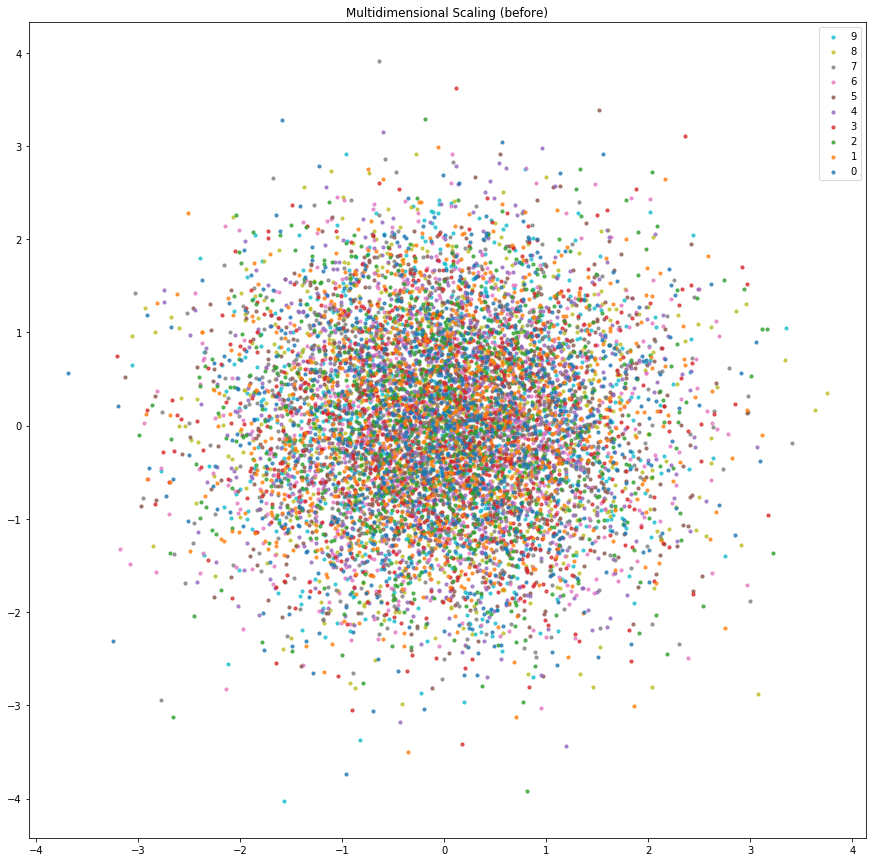

In [7]:
def visualize(X, title=""):
    colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]
    x = [x[0] for x in X]
    y = [x[1] for x in X]
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title(title)
    n = len(x_prime) // 10
    for i in reversed(range(10)):
        ax.scatter(x[i*n:(i+1)*n], y[i*n:(i+1)*n],
                   s=10.0, c=colors[i], label=str(i), alpha=0.75)
    ax.legend()

# Show X_prime before optimization
visualize(x_prime, title="Multidimensional Scaling (before)")

In [8]:
# Define optimizer
optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)
tf.global_variables_initializer().run()

In [9]:
# Minimize the loss
num_iter = 1000
loss_values = []
progress = FloatProgress(min=0, max=num_iter); display(progress)
for i in range(num_iter):
    progress.description = "Epoch %i/%i" % (i, num_iter)
    _, l = sess.run([optim, loss], feed_dict = { D: D_matrix })
    loss_values.append(l)
    progress.value += 1

A Jupyter Widget

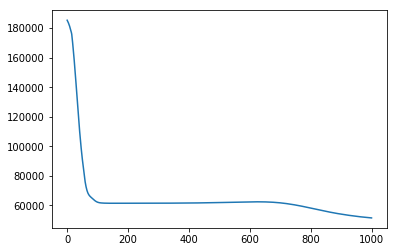

In [10]:
plt.plot(loss_values)
plt.show()

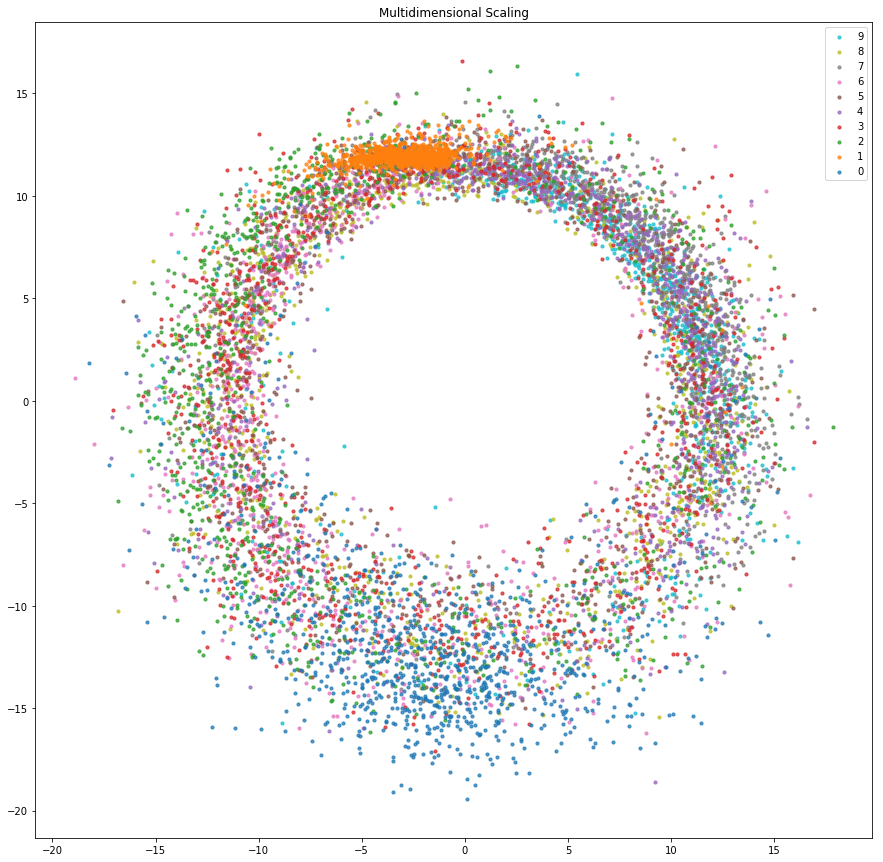

In [11]:
x_prime = sess.run(X_prime)
visualize(x_prime, title="Multidimensional Scaling")

We observe that 1s and 0s have little overlap as they are very distinct (circle vs a line).
Otherwise, the other numbers seems to group a bit (2s are in the upper-right, and 9s in the upper-left), but thend to blend together a bit more.